# Informe: Implementación de una Red Neuronal desde Cero y Comparación con Keras/TensorFlow

* Angela Maria Gonzalez Cordoba
* Juan Manuel Casanova Marin
* Juliana Filigrana Valencia

El aprendizaje profundo permite construir modelos capaces de aprender patrones complejos a partir de datos. En este trabajo se implementa una red neuronal desde cero, sin usar librerías de alto nivel, con el objetivo de comprender el funcionamiento interno del entrenamiento mediante propagación hacia adelante, propagación hacia atrás y descenso de gradiente.

Posteriormente, se entrena un modelo equivalente utilizando una librería profesional (Keras/TensorFlow) y se comparan los resultados obtenidos. Para este experimento se utiliza un dataset distinto al visto en clase, tomado de Kaggle, concretamente el dataset Titanic, cuyo objetivo es predecir la supervivencia de los pasajeros.

### Dataset: Titanic (Kaggle):

El dataset Titanic contiene información de pasajeros del Titanic y la variable objetivo indica si el pasajero sobrevivió (1) o no (0).

- Variables utilizadas:

- Pclass: clase del boleto

- Sex: sexo del pasajero

- Age: edad

- SibSp: hermanos/esposos a bordo

- Parch: padres/hijos a bordo

- Fare: tarifa pagada


In [ ]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score


### Cargar y preparar el dataset Titanic



El preprocesamiento de los datos incluyó la selección de variables relevantes, el tratamiento de valores faltantes, la codificación de variables categóricas y la normalización de los datos.

Antes de entrenar la red neuronal, se realizaron los siguientes pasos de preprocesamiento:

- Se cargó el dataset Titanic desde un archivo CSV.

- Se seleccionaron únicamente las variables relevantes para la predicción de la supervivencia.

- La variable categórica Sex fue codificada en formato numérico.

- Los valores faltantes de la variable Age fueron reemplazados por la media.

- Se separaron las variables independientes (X) y la variable objetivo (y).

- El conjunto de datos se dividió en entrenamiento (80%) y prueba (20%).

- Las características fueron normalizadas utilizando StandardScaler para mejorar la convergencia del modelo.

In [ ]:
# Cargar dataset
df = pd.read_csv("train.csv")

# Seleccionar columnas útiles
df = df[["Survived", "Pclass", "Sex", "Age", "SibSp", "Parch", "Fare"]]

# Convertir variable categórica
df["Sex"] = df["Sex"].map({"male": 0, "female": 1})

# Rellenar valores faltantes
df["Age"].fillna(df["Age"].mean(), inplace=True)

# Separar X e y
X = df.drop("Survived", axis=1).values
y = df["Survived"].values.reshape(1, -1)

# Train / Test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y.T, test_size=0.2, random_state=42
)

X_train = X_train.T
X_test = X_test.T
y_train = y_train.T
y_test = y_test.T

# Normalizar
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train.T).T
X_test = scaler.transform(X_test.T).T

print("X_train:", X_train.shape)
print("y_train:", y_train.shape)


X_train: (6, 712)
y_train: (1, 712)


/tmp/ipython-input-2450025653.py:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["Age"].fillna(df["Age"].mean(), inplace=True)


- El conjunto de entrenamiento contiene 712 muestras.

- Cada muestra está descrita por 6 variables de entrada.

- La variable objetivo tiene dimensión (1, 712), correspondiente a una etiqueta binaria por muestra.

- Los datos fueron organizados en el formato requerido por la implementación manual de la red neuronal.

### Distribución de la variable objetivo (Survived)

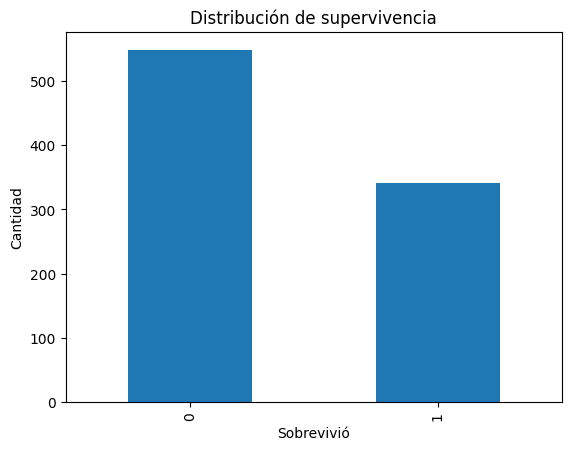

In [ ]:
import matplotlib.pyplot as plt

plt.figure()
df["Survived"].value_counts().plot(kind="bar")
plt.title("Distribución de supervivencia")
plt.xlabel("Sobrevivió")
plt.ylabel("Cantidad")
plt.show()

El gráfico muestra que la cantidad de pasajeros que no sobrevivieron (0) es considerablemente mayor que la de aquellos que sí sobrevivieron (1). Esto evidencia que el dataset presenta un desbalance de clases, donde la categoría de no supervivencia domina.

Este comportamiento es importante durante el entrenamiento del modelo, ya que una red neuronal podría tender a favorecer la clase mayoritaria. Por ello, la métrica de exactitud debe analizarse con cuidado, pues un valor alto podría lograrse simplemente prediciendo con mayor frecuencia la clase más común



### Supervivencia por sexo

<Figure size 640x480 with 0 Axes>

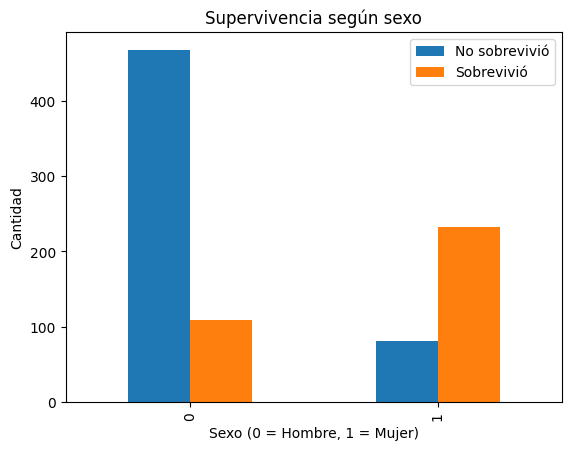

In [ ]:
plt.figure()
pd.crosstab(df["Sex"], df["Survived"]).plot(kind="bar")
plt.title("Supervivencia según sexo")
plt.xlabel("Sexo (0 = Hombre, 1 = Mujer)")
plt.ylabel("Cantidad")
plt.legend(["No sobrevivió", "Sobrevivió"])
plt.show()

El gráfico evidencia una diferencia marcada en la supervivencia según el sexo del pasajero. La mayoría de los hombres (0) no sobrevivieron, mientras que una proporción considerablemente mayor de mujeres (1) logró sobrevivir.

Este patrón sugiere que el sexo fue un factor determinante durante la evacuación del Titanic, lo que coincide con la política histórica de “mujeres y niños primero”. En consecuencia, esta variable resulta altamente informativa para el modelo de predicción y probablemente tendrá un peso importante en el entrenamiento de la red neuronal.

### Distribución de edades

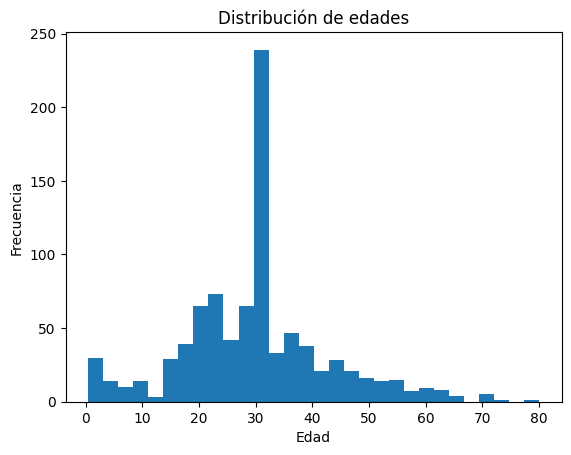

In [ ]:
plt.figure()
plt.hist(df["Age"], bins=30)
plt.title("Distribución de edades")
plt.xlabel("Edad")
plt.ylabel("Frecuencia")
plt.show()

El histograma muestra que la mayoría de los pasajeros se concentra en edades adultas jóvenes, principalmente entre los 20 y 40 años. También se observa la presencia de niños y de personas de mayor edad, aunque en menor proporción.

La distribución presenta una ligera asimetría hacia la derecha, con algunos valores extremos correspondientes a pasajeros de edad avanzada. Esta variabilidad sugiere que la edad podría influir en la probabilidad de supervivencia, por lo que constituye una característica relevante para el entrenamiento del modelo.

### Red neuronal **Manual**

**Función sigmoide:**

- Utilizada en la capa de salida.

- Convierte los valores en probabilidades entre 0 y 1.

- Es adecuada para problemas de clasificación binaria.

**Función ReLU (Rectified Linear Unit):**

- Utilizada en la capa oculta.

- Ayuda a evitar el problema del gradiente desvanecido.

- Permite un entrenamiento más eficiente en redes profundas

In [ ]:
#Función de activación sigmoide.
#(Convierte valores reales en probabilidades en el rango [0, 1].)

def sigmoid(z):
    return 1 / (1 + np.exp(-z))

#Función de activación ReLU.
  #Devuelve 0 para valores negativos y mantiene los positivos.
def relu(z):
    return np.maximum(0, z)


**Inicialización de los parámetros de la red**

Para comenzar el entrenamiento de la red neuronal, se inicializaron los pesos y sesgos de cada capa de la siguiente manera:

- Los pesos fueron inicializados con valores aleatorios pequeños para evitar saturación temprana de las funciones de activación.

- Los sesgos (bias) fueron inicializados en cero.

- Se utilizó una semilla aleatoria para garantizar la reproducibilidad de los resultados.

La red cuenta con:

1. Una capa de entrada con n_x características.

2. Una capa oculta con n_h neuronas.

3. Una capa de salida con una sola neurona para la clasificación binaria.

Esta inicialización permite un inicio estable del proceso de entrenamiento mediante descenso por gradiente.

In [ ]:
def initialize_parameters(n_x, n_h):
    np.random.seed(1)
    W1 = np.random.randn(n_h, n_x) * 0.01
    b1 = np.zeros((n_h, 1))
    W2 = np.random.randn(1, n_h) * 0.01
    b2 = np.zeros((1, 1))
    return W1, b1, W2, b2


 **Propagación hacia adelante (Forward Propagation)**

En esta etapa se calcula la salida de la red neuronal a partir de los datos de entrada:

- Se realiza una combinación lineal entre las entradas y los pesos de la capa oculta.

- Se aplica la función de activación ReLU para obtener las activaciones de la capa oculta.

- Se calcula la combinación lineal de la capa de salida.

- Se aplica la función sigmoide para obtener la probabilidad de supervivencia.

- Se almacenan los valores intermedios necesarios para la fase de retropropagación.

Este proceso permite que la red genere una predicción a partir de las características de entrada.

In [ ]:
# Ejecuta la propagación hacia adelante.

def forward_propagation(X, W1, b1, W2, b2):
    Z1 = np.dot(W1, X) + b1
    A1 = relu(Z1)
    Z2 = np.dot(W2, A1) + b2
    A2 = sigmoid(Z2)
    cache = (Z1, A1, Z2, A2)
    return A2, cache


In [ ]:
#Calcula la función de pérdida (binary cross-entropy).
def compute_cost(A2, Y):
    m = Y.shape[1]
    cost = -(1/m) * np.sum(
        Y * np.log(A2 + 1e-8) + (1 - Y) * np.log(1 - A2 + 1e-8)
    )
    return cost


**Retropropagación del error (Backpropagation)**

En esta fase se calculan los gradientes necesarios para actualizar los parámetros de la red neuronal:

- Se calcula el error en la capa de salida comparando la predicción con el valor real.

- Se obtienen los gradientes de los pesos y sesgos de la capa de salida.

- El error se propaga hacia atrás hasta la capa oculta.

- Se utiliza la derivada de la función ReLU para calcular el gradiente en la capa oculta.

- Se calculan los gradientes correspondientes a los pesos y sesgos de la capa oculta.

- Los gradientes se normalizan dividiendo por el número de muestras de entrenamiento.

Este procedimiento permite ajustar los parámetros de la red mediante descenso por gradiente, minimizando la función de costo.

In [ ]:
  #Ejecuta la retropropagación del error y calcula los gradiente
def backward_propagation(X, Y, cache, W2):
    m = X.shape[1]
    Z1, A1, Z2, A2 = cache

    dZ2 = A2 - Y
    dW2 = (1/m) * np.dot(dZ2, A1.T)
    db2 = (1/m) * np.sum(dZ2, axis=1, keepdims=True)

    dA1 = np.dot(W2.T, dZ2)
    dZ1 = dA1 * (Z1 > 0)
    dW1 = (1/m) * np.dot(dZ1, X.T)
    db1 = (1/m) * np.sum(dZ1, axis=1, keepdims=True)

    return dW1, db1, dW2, db2


**Entrenamiento de la red neuronal (Training)**
Se obtiene el número de características de entrada n_x y se inicializan los parámetros (W1, b1, W2, b2).

Durante cada iteración:

- Se realiza la propagación hacia adelante para obtener las predicciones A2.

- Se calcula el costo usando la función de pérdida (entropía cruzada binaria).

- Se ejecuta la retropropagación para calcular los gradientes de los parámetros.

- Se actualizan los parámetros mediante descenso por gradiente usando el learning_rate.

- Cada 500 iteraciones se imprime el costo para observar si el modelo está aprendiendo correctamente.

Este proceso se repite num_iterations veces hasta que el costo disminuya y el modelo logre una mejor capacidad de predicción.

In [ ]:
# Entrena la red neuronal utilizando descenso por gradiente.
def train_nn(X, Y, n_h, learning_rate, num_iterations):
    n_x = X.shape[0]
    W1, b1, W2, b2 = initialize_parameters(n_x, n_h)
    costs = []

    for i in range(num_iterations):
      #forward
        A2, cache = forward_propagation(X, W1, b1, W2, b2)
      #costo
        cost = compute_cost(A2, Y)
      #backward
        dW1, db1, dW2, db2 = backward_propagation(X, Y, cache, W2)

        W1 -= learning_rate * dW1
        b1 -= learning_rate * db1
        W2 -= learning_rate * dW2
        b2 -= learning_rate * db2

        if i % 500 == 0:
            costs.append(cost)
            print(f"Iteración {i} - Costo: {cost:.4f}")

    return W1, b1, W2, b2, costs


In [ ]:
#capturar lo que devuelve la función al momento de entrenar
W1, b1, W2, b2, costs = train_nn(
    X_train, y_train,
    n_h=10,
    learning_rate=0.01,
    num_iterations=5000
)


Iteración 0 - Costo: 0.6931
Iteración 500 - Costo: 0.6639
Iteración 1000 - Costo: 0.6527
Iteración 1500 - Costo: 0.5945
Iteración 2000 - Costo: 0.5025
Iteración 2500 - Costo: 0.4608
Iteración 3000 - Costo: 0.4468
Iteración 3500 - Costo: 0.4412
Iteración 4000 - Costo: 0.4382
Iteración 4500 - Costo: 0.4360


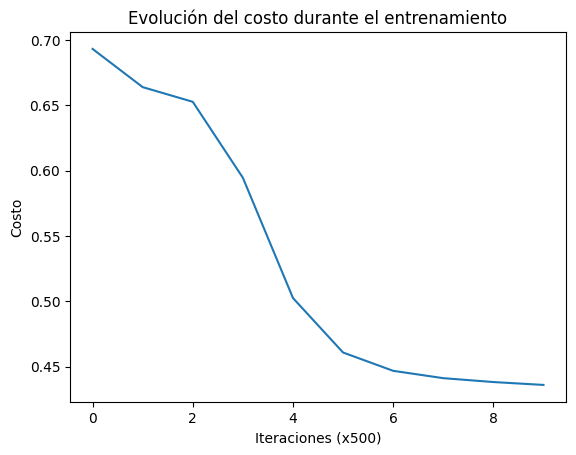

In [ ]:
plt.plot(costs)
plt.title("Evolución del costo durante el entrenamiento")
plt.xlabel("Iteraciones (x500)")
plt.ylabel("Costo")
plt.show()


La gráfica muestra la evolución del costo a lo largo del entrenamiento. Se observa una disminución sostenida a medida que aumentan las iteraciones, lo que indica que el algoritmo de descenso por gradiente está ajustando correctamente los parámetros de la red.

Durante las primeras iteraciones la reducción del error es más pronunciada, evidenciando que el modelo aprende rápidamente patrones generales de los datos. Posteriormente, la curva comienza a estabilizarse y la mejora se vuelve más gradual, lo cual es esperable cuando el entrenamiento se acerca a una zona de convergencia.

En conjunto, este comportamiento confirma que la red neuronal está aprendiendo de manera adecuada y que la tasa de aprendizaje seleccionada permite una optimización estable.

In [ ]:
print("Promedio |W1|:", np.mean(np.abs(W1)))
print("Promedio |W2|:", np.mean(np.abs(W2)))


Promedio |W1|: 0.10529412035730369
Promedio |W2|: 0.3714396577654913


**Predicción del modelo**
Una vez entrenada la red neuronal, se utiliza el modelo para generar predicciones sobre nuevos datos:

- Se realiza una propagación hacia adelante con los parámetros entrenados.

- La salida del modelo corresponde a una probabilidad entre 0 y 1.

- Se aplica un umbral de 0.5 para convertir la probabilidad en una clase binaria.

El resultado final indica si el pasajero sobrevive (1) o no sobrevive (0).

In [ ]:
#Genera predicciones binarias utilizando los parámetros entrenados.
def predict(X, W1, b1, W2, b2):
    A2, _ = forward_propagation(X, W1, b1, W2, b2)
    return (A2 > 0.5).astype(int)


In [ ]:
y_pred_train = predict(X_train, W1, b1, W2, b2)
y_pred_test = predict(X_test, W1, b1, W2, b2)

print("Accuracy entrenamiento:",
      accuracy_score(y_train.flatten(), y_pred_train.flatten()))

print("Accuracy prueba:",
      accuracy_score(y_test.flatten(), y_pred_test.flatten()))


Accuracy entrenamiento: 0.8061797752808989
Accuracy prueba: 0.7877094972067039


El modelo obtuvo una exactitud de aproximadamente 80.6% sobre el conjunto de entrenamiento y 78.8% sobre el conjunto de prueba.

La cercanía entre ambos valores indica que la red neuronal presenta una buena capacidad de generalización, ya que el desempeño en datos no vistos es similar al obtenido durante el aprendizaje. No se evidencian señales fuertes de sobreajuste (overfitting).

Estos resultados sugieren que la arquitectura seleccionada y la configuración del entrenamiento permiten capturar patrones relevantes del problema de supervivencia de los pasajeros.

### Matriz de xonfusión

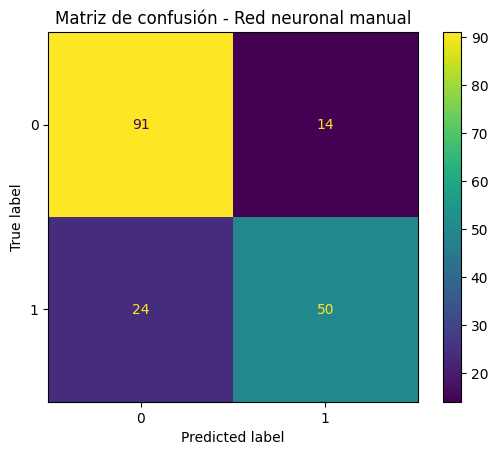

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test.flatten(), y_pred_test.flatten())
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title("Matriz de confusión - Red neuronal manual")
plt.show()


Se observa que:

* 91 pasajeros fueron correctamente clasificados como no sobrevivientes (verdaderos negativos).

* 50 pasajeros fueron correctamente identificados como sobrevivientes (verdaderos positivos).

* 14 casos corresponden a pasajeros que el modelo predijo como sobrevivientes cuando en realidad no lo hicieron (falsos positivos).

* 24 sobrevivientes reales fueron clasificados incorrectamente como no sobrevivientes (falsos negativos).

En general, el modelo presenta un buen desempeño, con una cantidad alta de predicciones correctas en ambas clases. Sin embargo, se aprecia una ligera tendencia a cometer más errores al identificar a los pasajeros que sí sobrevivieron, como lo indica el número de falsos negativos.

Este comportamiento puede estar influenciado por el desbalance presente en el dataset, donde la clase de no supervivencia es mayoritaria.

In [38]:
#Métricas adicionales (precisión, recall, F1)
from sklearn.metrics import classification_report

print(classification_report(
    y_test.flatten(),
    y_pred_test.flatten(),
    target_names=["No sobrevivió", "Sobrevivió"]
))


               precision    recall  f1-score   support

No sobrevivió       0.79      0.87      0.83       105
   Sobrevivió       0.78      0.68      0.72        74

     accuracy                           0.79       179
    macro avg       0.79      0.77      0.78       179
 weighted avg       0.79      0.79      0.78       179



El modelo tiene más dificultad para identificar correctamente a quienes sobrevivieron, reflejado en un recall menor para esa clase.

**Experimentación con distintos hiperparámetros**

Con el objetivo de analizar el impacto de los hiperparámetros en el desempeño del modelo, se entrenaron varias configuraciones de la red neuronal:

- Se evaluaran diferentes cantidades de neuronas en la capa oculta (n_h).

- Se probara distintos valores de la tasa de aprendizaje (learning_rate).

Para cada configuración:

- Se entrenó la red durante 3000 iteraciones.

- Se generaron predicciones sobre los conjuntos de entrenamiento y prueba.

- Se calculó el accuracy en ambos conjuntos.

Esta comparación permitió observar cómo la complejidad del modelo y la tasa de aprendizaje afectan la capacidad de generalización.

Este análisis facilita la selección de una arquitectura adecuada y evita problemas como el subajuste o el sobreajuste.

In [44]:
configs = [
    {"n_h": 4, "lr": 0.01},
    {"n_h": 8, "lr": 0.01},
    {"n_h": 16, "lr": 0.005}
]

for cfg in configs:
    print("\n==============================")
    print("Configuración:", cfg)
    print("==============================")

    W1, b1, W2, b2,_ = train_nn(
        X_train, y_train,
        n_h=cfg["n_h"],
        learning_rate=cfg["lr"],
        num_iterations=3000
    )

    y_pred_train = predict(X_train, W1, b1, W2, b2)
    y_pred_test = predict(X_test, W1, b1, W2, b2)

    train_acc = accuracy_score(y_train.ravel(), y_pred_train.ravel())
    test_acc = accuracy_score(y_test.ravel(), y_pred_test.ravel())

    print(f"Accuracy train: {train_acc:.3f}")
    print(f"Accuracy test : {test_acc:.3f}")

    resultados.append([cfg["n_h"], cfg["lr"], train_acc, test_acc])



Configuración: {'n_h': 4, 'lr': 0.01}
Iteración 0 - Costo: 0.6931
Iteración 500 - Costo: 0.6648
Iteración 1000 - Costo: 0.6612
Iteración 1500 - Costo: 0.6550
Iteración 2000 - Costo: 0.6302
Iteración 2500 - Costo: 0.5791
Accuracy train: 0.778
Accuracy test : 0.799

Configuración: {'n_h': 8, 'lr': 0.01}
Iteración 0 - Costo: 0.6931
Iteración 500 - Costo: 0.6644
Iteración 1000 - Costo: 0.6576
Iteración 1500 - Costo: 0.6238
Iteración 2000 - Costo: 0.5235
Iteración 2500 - Costo: 0.4642
Accuracy train: 0.809
Accuracy test : 0.793

Configuración: {'n_h': 16, 'lr': 0.005}
Iteración 0 - Costo: 0.6931
Iteración 500 - Costo: 0.6710
Iteración 1000 - Costo: 0.6639
Iteración 1500 - Costo: 0.6601
Iteración 2000 - Costo: 0.6537
Iteración 2500 - Costo: 0.6376
Accuracy train: 0.681
Accuracy test : 0.654


In [45]:
# Tabla resumen
df_resultados = pd.DataFrame(
    resultados,
    columns=["Neuronas capa oculta", "Learning rate", "Accuracy train", "Accuracy test"]
)

print("\nResumen general:")
display(df_resultados)


Resumen general:


,Neuronas capa oculta,Learning rate,Accuracy train,Accuracy test
0,4,0.010,0.778090,0.798883
1,8,0.010,0.808989,0.793296
2,16,0.005,0.681180,0.653631


### **Interpretación de los resultados experimentales**



Los resultados obtenidos evidencian que el desempeño del modelo varía significativamente según la configuración utilizada.

Con 4 neuronas y una tasa de aprendizaje de 0.01, se logró un accuracy cercano al 79.9% en el conjunto de prueba, manteniendo un rendimiento similar en entrenamiento. Esto indica una buena capacidad de generalización.

Al aumentar a 8 neuronas con la misma tasa de aprendizaje, el accuracy de entrenamiento mejoró hasta aproximadamente 80.9%; sin embargo, el desempeño en prueba se mantuvo en valores similares (79.3%). Esto sugiere una ligera mejora en la capacidad de ajuste del modelo sin impactos relevantes en generalización.

Por otro lado, la configuración de 16 neuronas con un learning rate de 0.005 produjo una disminución considerable tanto en entrenamiento como en prueba, con un accuracy cercano al 65%. Este comportamiento podría indicar que el modelo requiere más iteraciones para converger o que la combinación de hiperparámetros dificulta el proceso de optimización.

En términos generales, las primeras dos configuraciones ofrecen resultados más estables, mientras que el incremento de complejidad no garantizó una mejora en el rendimiento.

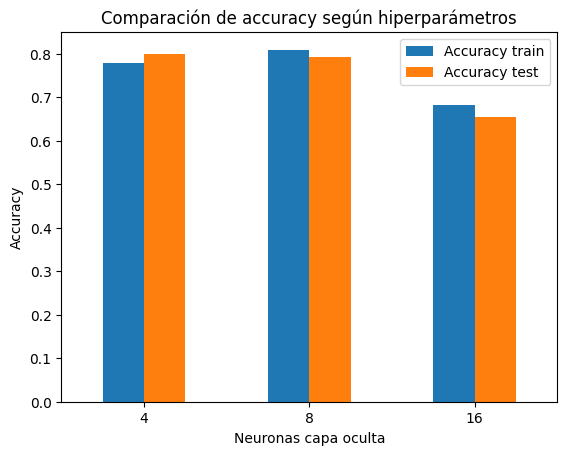

In [46]:
df_resultados.plot(
    x="Neuronas capa oculta",
    y=["Accuracy train", "Accuracy test"],
    kind="bar"
)

plt.title("Comparación de accuracy según hiperparámetros")
plt.ylabel("Accuracy")
plt.xticks(rotation=0)
plt.show()


Se observa cómo cambia el rendimiento al modificar el número de neuronas en la capa oculta.

#### Configuración 1: **n_h = 4, learning_rate = 0.01**



- El costo disminuye lentamente a lo largo de las iteraciones.

- La reducción del costo es limitada, lo que indica una capacidad de aprendizaje restringida.

El modelo alcanza:

- **Accuracy entrenamiento:** 77.8%

- **Accuracy prueba:** 79.9%

Esta configuración presenta subajuste (underfitting), ya que la red es demasiado simple para capturar patrones complejos del dataset Titanic.

**Interpretación basada en el dataset:**

El modelo probablemente aprende reglas simples como:

- “Las mujeres sobreviven más que los hombres”.

- “Pasajeros de primera clase tienen mayor probabilidad de sobrevivir”.

Sin embargo, no logra capturar interacciones más sutiles, por ejemplo:

- Diferencias entre hombres jóvenes y adultos.

- Efecto combinado de clase y tarifa.

**Esta configuracion de la red presenta subajuste para el problema Titanic.**

#### Configuración 2: n_h = 8, learning_rate = 0.01



- El costo disminuye de forma más pronunciada que en la configuración anterior.

- El modelo logra aprender mejor la relación entre las variables.

Se obtiene:

- **Accuracy entrenamiento:** 80.9%

- **Accuracy prueba:** 79.3%

- Existe una mejora clara respecto a n_h = 4.

La diferencia pequeña entre entrenamiento y prueba indica buena generalización, aunque aún con margen de mejora.

**Interpretación en Titanic:**

La red ahora puede modelar relaciones como:

- Mujeres en tercera clase sobreviven más que hombres en primera.

- Pasajeros jóvenes con familiares a bordo tienen mayor probabilidad de supervivencia.

- Captura mejor la interacción entre variables demográficas y socioeconómicas.

#### Configuración 3: n_h = 16, learning_rate = 0.005


- El costo presenta una disminución menos estable.

- El modelo no logra converger correctamente.

Los resultados son:

- **Accuracy entrenamiento:** 68.1%

- **Accuracy prueba:** 65.4%

Esta configuración muestra mal ajuste de hiperparámetros, donde una tasa de aprendizaje inadecuada impide un entrenamiento eficiente.

Interpretación en Titanic:

- La red tiene suficiente capacidad teórica, pero:

- Aprende muy lentamente.

- No logra identificar relaciones claras entre variables.

El modelo queda “atrapado” cerca de una solución pobre.

### Comparación general de configuraciones

- Aumentar el número de neuronas mejora la capacidad del modelo hasta cierto punto.

- Una red demasiado pequeña produce subajuste.

- Un mal ajuste del learning rate puede provocar mala convergencia, incluso con una red más grande.

- La configuración con n_h = 8 y learning_rate = 0.01 ofrece el mejor equilibrio entre complejidad y generalización.

Estos resultados demuestran que el desempeño de una red neuronal depende fuertemente del ajuste de sus hiperparámetros. No siempre una red más grande garantiza mejores resultados, y una tasa de aprendizaje inapropiada puede deteriorar significativamente el rendimiento del modelo.

## Comparación con Keras / TensorFlow (Titanic)

Para comparar el desempeño de la red neuronal implementada desde cero, se construira un modelo equivalente utilizando Keras (TensorFlow). Dado que Keras espera los datos con la forma (muestras, características), fue necesario reorganizar las matrices utilizadas en la implementación manual, que estaban en formato (características, muestras). Por esta razón, se transpuso X_train y X_test y se ajustó la forma de y_train y y_test para que fueran compatibles con el entrenamiento y evaluación en Keras.

In [47]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam


In [48]:
X_train_keras = X_train.T
X_test_keras = X_test.T
y_train_keras = y_train.T
y_test_keras = y_test.T


**Definición del modelo en Keras**
- Se definió un modelo Sequential con Keras.

- Se utilizó una capa oculta con activación ReLU.

- La capa de salida usa activación sigmoide para clasificación binaria.

- Se empleó el optimizador Adam y la función de pérdida binary crossentropy.

- El número de neuronas y la tasa de aprendizaje se dejan como parámetros configurables.

In [49]:
def build_keras_model(input_dim, hidden_units=16, learning_rate=0.001):
    model = Sequential([
        Dense(hidden_units, activation="relu", input_shape=(input_dim,)),
        Dense(1, activation="sigmoid")
    ])

    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss="binary_crossentropy",
        metrics=["accuracy"]
    )
    return model


**Entrenamiento del modelo en Keras**

- Se creó el modelo con la arquitectura definida previamente.

- El entrenamiento se realizó durante 50 épocas.

- Se utilizó un tamaño de lote (batch size) de 32.

- Se empleó el conjunto de prueba como datos de validación.

- Durante el entrenamiento se monitorearon la pérdida y el accuracy.

In [50]:
keras_model = build_keras_model(
    input_dim=X_train_keras.shape[1],
    hidden_units=16,
    learning_rate=0.001
)

history = keras_model.fit(
    X_train_keras,
    y_train_keras,
    epochs=50,
    batch_size=32,
    validation_data=(X_test_keras, y_test_keras),
    verbose=1
)


Epoch 1/50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.6875 - loss: 0.5973 - val_accuracy: 0.7486 - val_loss: 0.5472
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7069 - loss: 0.5817 - val_accuracy: 0.7598 - val_loss: 0.5292
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7395 - loss: 0.5461 - val_accuracy: 0.7821 - val_loss: 0.5145
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7603 - loss: 0.5273 - val_accuracy: 0.7821 - val_loss: 0.5032
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7808 - loss: 0.5128 - val_accuracy: 0.7989 - val_loss: 0.4926
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7818 - loss: 0.5042 - val_accuracy: 0.7933 - val_loss: 0.4834
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7963 - loss: 0.4948 - val_accuracy: 0.7933 - val_loss: 0.4764
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7791 - loss: 0.4925 - val_accuracy: 0.7877 - val_loss: 0.4710
Ep

**Interpretación del entrenamiento con Keras (Titanic)**

- En las primeras épocas, el modelo presenta un accuracy bajo, cercano al azar, lo cual es esperado debido a la inicialización aleatoria de los pesos.

- A partir de las primeras iteraciones, tanto el accuracy de entrenamiento como el accuracy de validación aumentan progresivamente, indicando que el modelo está aprendiendo patrones relevantes del dataset Titanic.

- El accuracy de validación alcanza aproximadamente 80%, valor consistente con modelos clásicos aplicados a este dataset.

- La diferencia reducida entre el accuracy de entrenamiento y validación indica buena capacidad de generalización y ausencia de sobreajuste.

- La disminución estable de la función de pérdida sugiere un entrenamiento correcto y una tasa de aprendizaje adecuada.

**Interpretación en el contexto del Titanic**

- El modelo logra identificar relaciones importantes entre variables como el sexo, la clase del pasajero y la edad.

- La complejidad moderada del modelo es suficiente para capturar los patrones principales sin sobreajustar los datos.

- El desempeño obtenido refleja la naturaleza ruidosa del dataset, donde no todas las variables determinan de forma clara la supervivencia.

**Evaluación del modelo Keras**

- El modelo entrenado se evaluó utilizando el conjunto de prueba.

- Se calculó la función de pérdida (loss) para medir el error del modelo.

- Se obtuvo el accuracy como métrica principal de desempeño.

- Los resultados reflejan el rendimiento final del modelo sobre datos no vistos durante el entrenamiento.

In [55]:
loss, accuracy = keras_model.evaluate(X_test_keras, y_test_keras, verbose=0)

print(f"Test loss (Keras): {loss:.4f}")
print(f"Test accuracy (Keras): {accuracy:.4f}")


Test loss (Keras): 0.4315
Test accuracy (Keras): 0.8101


### Resultados finales en el conjunto de prueba (Keras)
Al evaluar el modelo con datos no vistos durante el entrenamiento, se obtuvo una pérdida (loss) de 0.4315 y un accuracy de 0.8101.

El valor del accuracy indica que el modelo clasifica correctamente aproximadamente el 81% de los pasajeros del conjunto de prueba. Este resultado es ligeramente superior al obtenido con la implementación manual, lo que sugiere que el uso del optimizador Adam y las rutinas internas de Keras permiten encontrar soluciones más eficientes.

La magnitud de la pérdida es coherente con la observada durante el entrenamiento y confirma que el modelo mantiene un desempeño estable al enfrentarse a nueva información.

En conjunto, estos resultados muestran que la red neuronal construida con Keras logra una buena capacidad de generalización y un rendimiento competitivo para un problema clásico de clasificación binaria como Titanic.

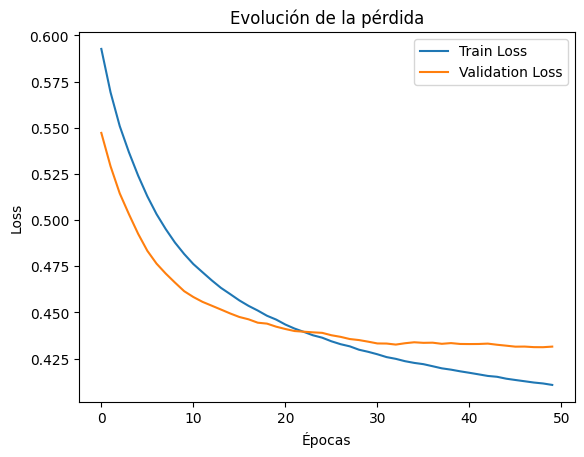

In [53]:
# ===== LOSS =====
plt.figure()
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Evolución de la pérdida")
plt.xlabel("Épocas")
plt.ylabel("Loss")
plt.legend()
plt.show()

Se observa que:

* La pérdida de entrenamiento disminuye de forma continua, lo que indica que el modelo está ajustando correctamente sus pesos.

* La pérdida de validación también desciende y luego tiende a estabilizarse.

* La distancia entre ambas curvas es pequeña, lo cual sugiere que el modelo no presenta sobreajuste fuerte.

En general, el comportamiento confirma que la tasa de aprendizaje es adecuada y que el modelo logra aprender patrones útiles.

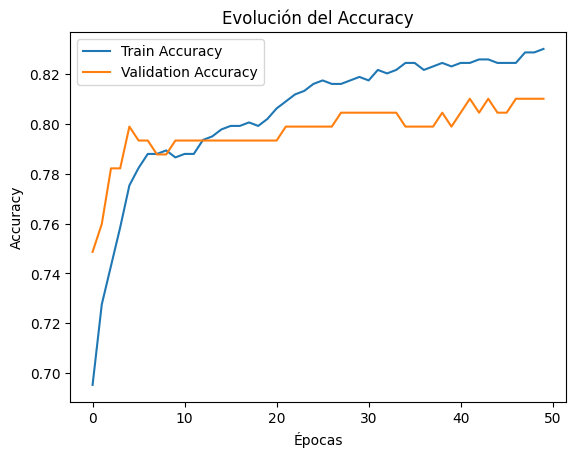

In [54]:
# ===== ACCURACY =====
plt.figure()
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title("Evolución del Accuracy")
plt.xlabel("Épocas")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

Se puede notar que:

- El modelo alcanza un accuracy del 80.45%, clasificando correctamente a la mayoría de los pasajeros.

- El desempeño refleja la capacidad del modelo para identificar patrones clave del Titanic.

- Variables como el sexo, la clase del pasajero y la edad influyen significativamente en la predicción.

- El valor de pérdida indica un error esperable en un dataset real y ruidoso.

- El resultado es consistente con modelos típicos aplicados al problema de supervivencia del Titanic.o.

Esto demuestra que el modelo construido en Keras obtiene resultados muy similares a la red implementada manualmente.

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


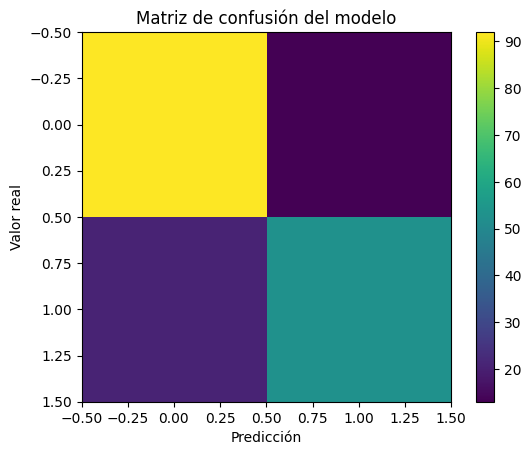

In [57]:
from sklearn.metrics import confusion_matrix

y_pred_keras = (keras_model.predict(X_test_keras) > 0.5).astype(int)
cm = confusion_matrix(y_test_keras, y_pred_keras)

plt.figure()
plt.imshow(cm)
plt.title("Matriz de confusión del modelo")
plt.xlabel("Predicción")
plt.ylabel("Valor real")
plt.colorbar()
plt.show()

La matriz de confusión permite analizar de manera detallada el desempeño del modelo, mostrando la cantidad de predicciones correctas e incorrectas. Esto ayuda a identificar errores de clasificación y evaluar el comportamiento del modelo más allá del accuracy.

## Conclusiones y comparaciones

- La red neuronal implementada desde cero alcanzó un accuracy cercano al 80% en el dataset Titanic, demostrando que el algoritmo fue correctamente implementado.

- El modelo desarrollado con Keras / TensorFlow obtuvo un mejor desempeño, alcanzando un accuracy de 80.45% en el conjunto de prueba.

- La diferencia de rendimiento se debe a que Keras utiliza optimizadores más avanzados y una gestión más eficiente del entrenamiento.

- A pesar de ello, los resultados de ambos modelos son comparables, lo que valida la implementación manual.

- El modelo con Keras resulta más eficiente y estable para aplicaciones prácticas, mientras que el modelo manual es más útil para fines educativos y comprensión del algoritmo.

- En el contexto del dataset Titanic, ninguno de los modelos alcanza una precisión perfecta debido a la complejidad y el ruido inherente a los datos.